In [3]:
import numpy as np
import pandas as pd
import requests
from scipy.stats import norm, chi2, genpareto
import matplotlib.pyplot as plt
from arch import arch_model
%matplotlib inline

In [4]:
res = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol=sh000001&scale=240&ma=no&datalen=10000')
# scale单位是分钟。这个地址数据很全，开盘、收盘、最高、最低、成交量。
# ma 移动平均参数
# datalen 数据量参数
data_json = res.json()
data = pd.DataFrame(data_json)
data.to_csv('data_ssec.csv')
print(data)

             day      open      high       low     close       volume
0     1990-12-19    96.050    99.980    95.790    99.980       126000
1     1990-12-20   104.300   104.390    99.980   104.390        19700
2     1990-12-21   109.070   109.130   103.730   109.130         2800
3     1990-12-24   113.570   114.550   109.130   114.550         3200
4     1990-12-25   120.090   120.250   114.550   120.250         1500
...          ...       ...       ...       ...       ...          ...
7930  2023-06-07  3197.468  3210.330  3188.005  3197.759  25806340000
7931  2023-06-08  3194.835  3225.526  3180.535  3213.586  29353074100
7932  2023-06-09  3213.033  3231.406  3206.103  3231.406  31415550100
7933  2023-06-12  3225.305  3239.437  3210.714  3228.834  31378444400
7934  2023-06-13  3223.896  3235.085  3215.499  3233.673  28062845400

[7935 rows x 6 columns]


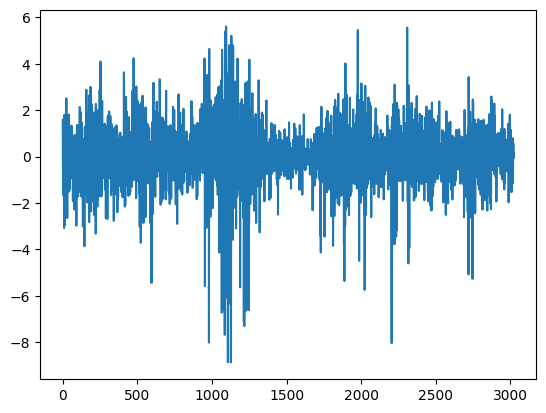

In [5]:
data = pd.read_csv('data_ssec.csv')
data['return'] = np.log(data['close']) - np.log(data['close'].shift(periods=1))
data['day'] = pd.to_datetime(data['day'], format='%Y-%m-%d')
ind = data['day'] >= pd.to_datetime('2011-01-01', format='%Y-%m-%d')
r = data[ind]['return'].values*100
plt.plot(r)
plt.show()

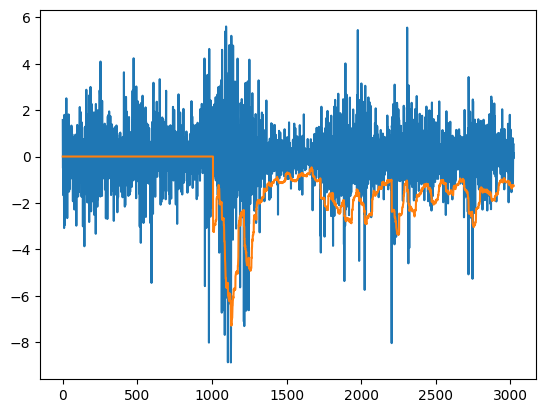

In [6]:
# RiskMetrics方法
l = np.fix(len(r)/3).astype(int)  用np.fix将选取
VaR_RM = np.zeros(len(r))
qalpha = norm.ppf(0.05)
for i in range(l, len(r)):
    mhat, shat = norm.fit(r[i-50:i])
    VaR_RM[i] = -(mhat + qalpha*shat)
plt.plot(r)
plt.plot(VaR_RM*-1)
plt.show()

In [ ]:
l = np.fix(len(r)/3).astype(int)
VaR_GN = np.zeros(len(r))
qalpha = norm.ppf(0.05)
for i in range(l, len(r)):
    am_ar_garch = arch_model(r[:i], mean='ar', lags=1, vol='garch', dist='normal', p=2, q=2)
    res_ar_garch = am_ar_garch.fit()
    a = res_ar_garch.forecast(horizon=1, align='origin')
    mu = a.mean['h.1'].iloc[-1]
    sigma = a.variance['h.1'].iloc[-1]
    VaR_GN[i] = -(mu + qalpha * np.sqrt(sigma))
    
plt.plot(r)
plt.plot(VaR_GN*-1)
plt.show()

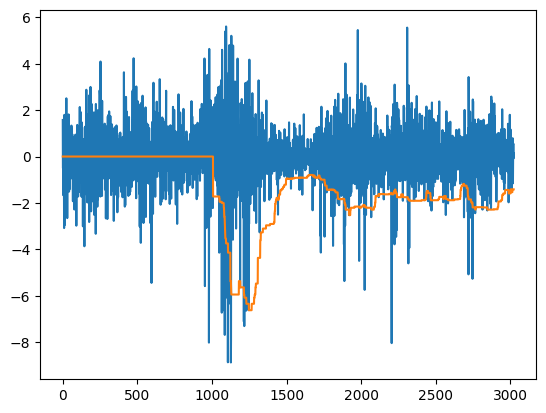

In [7]:
# 历史模拟方法
l = np.fix(len(r)/3).astype(int)
VaR_HS = np.zeros(len(r))
qalpha = int(200*0.05)
for i in range(l, len(r)):
    his_sample = r[i-200:i]
    his_sample = np.sort(his_sample)
    VaR_HS[i] = -his_sample[qalpha-1]
plt.plot(r)
plt.plot(VaR_HS*-1)
plt.show()

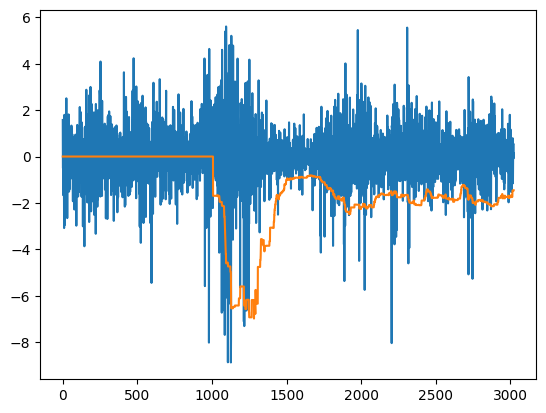

In [8]:
# POT方法
l = np.fix(len(r)/3).astype(int)
VaR_EVT = np.zeros(len(r))
alpha = 0.05
for i in range(l, len(r)):
    his_sample = r[i-200:i]
    his_sample = np.sort(his_sample)
    ind = np.ceil(len(his_sample)*0.1).astype(int)
    evt_sample = np.abs(his_sample[:ind])
    u = evt_sample[-1]
    evt_sample = evt_sample - u
    evt_sample = np.delete(evt_sample, -1)

    n = len(his_sample)
    Nu = len(evt_sample)

    parmhat = genpareto.fit(evt_sample, floc=0)
    kHat = parmhat[0]; # Tail index parameter
    sigmaHat = parmhat[2]; # Scale parameter
    VaR_EVT[i] = u + sigmaHat / kHat * ((alpha * n / Nu) ** -kHat - 1)
plt.plot(r)
plt.plot(VaR_EVT*-1)
plt.show()

In [ ]:
data = pd.DataFrame({'return': r, 'VaR_RM': VaR_RM, 'VaR_GN': VaR_GN, 'VaR_HS': VaR_HS, 'VaR_EVT': VaR_EVT})
data.to_csv('Data_VaR.csv')

In [ ]:
def myfun_Kupiec(r, VaR, pstar):
    N = np.sum(r > VaR)
    T = len(r)
    LRuc = -2*((T-N)*np.log(1-pstar)+N*np.log(pstar)) + 2*((T-N)*np.log(1-N/T)+N*np.log(N/T))
    pvalue_LRuc = 1 - chi2.cdf(LRuc, 1)
    return LRuc, pvalue_LRuc

def myfun_Christoffersen(r, VaR):
    ind = r > VaR
    ind1 = ind[:-1]
    ind2 = ind[1:]
    n00 = np.sum((ind1==0) & (ind2==0))
    n01 = np.sum((ind1==0) & (ind2==1))
    n10 = np.sum((ind1==1) & (ind2==0))
    n11 = np.sum((ind1==1) & (ind2==1))

    Pi01 = n01/(n01+n00)
    Pi11 = n11/(n10+n11)
    Pi2 = (n01+n11)/(n00+n01+n10+n11)

    LRind = (n00+n10)*np.log(1-Pi2) + (n01+n11)*np.log(Pi2) - \
            n00*np.log(1-Pi01) - n01*np.log(Pi01) - n10*np.log(1-Pi11) - n11*np.log(Pi11)
    LRind = LRind*-2
    pvalue_LRind = 1 - chi2.cdf(LRind, 1)
    return LRind, pvalue_LRind

def myfun_Kupiec_Christoffersen(LRuc, LRind):
    LRcc = LRuc + LRind
    pvalue_LRcc = 1 - chi2.cdf(LRcc, 2)
    return LRcc, pvalue_LRcc

data = pd.read_csv('Data_VaR.csv')
ind = data['VaR_RM'] > 0
r = data.loc[ind, ['return']].values*-1
VaR_RM = data.loc[ind, ['VaR_RM']].values
VaR_GN = data.loc[ind, ['VaR_GN']].values
VaR_HS = data.loc[ind, ['VaR_HS']].values
VaR_EVT = data.loc[ind, ['VaR_EVT']].values

pstar = 0.05;
[LRuc_RM, pvalue_LRuc_RM] = myfun_Kupiec(r, VaR_RM, pstar)
[LRind_RM, pvalue_LRind_RM] = myfun_Christoffersen(r, VaR_RM)
[LRcc_RM, pvalue_LRcc_RM] = myfun_Kupiec_Christoffersen(LRuc_RM, LRind_RM)

[LRuc_GN, pvalue_LRuc_GN] = myfun_Kupiec(r, VaR_GN, pstar)
[LRind_GN, pvalue_LRind_GN] = myfun_Christoffersen(r, VaR_GN)
[LRcc_GN, pvalue_LRcc_GN] = myfun_Kupiec_Christoffersen(LRuc_GN, LRind_GN)

[LRuc_HS, pvalue_LRuc_HS] = myfun_Kupiec(r, VaR_HS, pstar)
[LRind_HS, pvalue_LRind_HS] = myfun_Christoffersen(r, VaR_HS)
[LRcc_HS, pvalue_LRcc_HS] = myfun_Kupiec_Christoffersen(LRuc_HS, LRind_HS)

[LRuc_EVT, pvalue_LRuc_EVT] = myfun_Kupiec(r, VaR_EVT, pstar)
[LRind_EVT, pvalue_LRind_EVT] = myfun_Christoffersen(r, VaR_EVT)
[LRcc_EVT, pvalue_LRcc_EVT] = myfun_Kupiec_Christoffersen(LRuc_EVT, LRind_EVT)


print('{:12s}, {:>12s}, {:>12s}, {:>12s}, {:>12s}, {:>12s}, {:>12s}'.format('', 'LRuc', 'pLRuc', 'LRind', 'pLRind', 'LRcc', 'pLRcc'))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('RiskMetrics', LRuc_RM, pvalue_LRuc_RM, LRind_RM, pvalue_LRind_RM, LRcc_RM, pvalue_LRcc_RM))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('GarchNormal', LRuc_GN, pvalue_LRuc_GN, LRind_GN, pvalue_LRind_GN, LRcc_GN, pvalue_LRcc_GN))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('HisSim', LRuc_HS, pvalue_LRuc_HS, LRind_HS, pvalue_LRind_HS, LRcc_HS, pvalue_LRcc_HS))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('EVT GPD', LRuc_EVT, pvalue_LRuc_EVT, LRind_EVT, pvalue_LRind_EVT,LRcc_EVT, pvalue_LRcc_EVT))